# Exercise 1

In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.adex_model import AdEx
from neurodynex3.tools import input_factory, plot_tools

In [2]:
#parameters
MEMBRANE_TIME_SCALE_tau_d= 8 * b2.ms
MEMBRANE_CAPACITANCE_Cd = 170 * b2.pF #Vérifier pour pF
V_REST = -70.0 * b2.mV
ADAPTATION_TIME_CONSTANT_tau_w = 30.0 * b2.ms
V_DENDRITE = -38.0 * b2.mV
D_DENDRITE = 6.0 * b2.mV
a = -13.0 * b2.nS
g = 1200 * b2.pA

In [3]:
def simulate_dendrite(
        tau_d = MEMBRANE_TIME_SCALE_tau_d,
        C = MEMBRANE_CAPACITANCE_Cd,
        v_rest = V_REST,
        tau_w = ADAPTATION_TIME_CONSTANT_tau_w,
        I_stim=input_factory.get_zero_current(),
        V_d = V_DENDRITE,
        D_d = D_DENDRITE,
        a = a,
        g = g,
        simulation_time=200 * b2.ms):

    # EXP-IF
    eqs = """
        dv/dt = -(v-v_rest)/tau_d + (I_stim(t,i) + w + g*f)/C : volt
        dw/dt=(-w + a*(v-v_rest))/tau_w : amp
        f = 1/(1 + exp(-(v-V_d)/D_d)) : 1
        """

    neuron = b2.NeuronGroup(1, model=eqs, method="euler")

    # initial values of v and w is set here:
    neuron.v = v_rest
    neuron.w = 0.0 * b2.pA

    # Monitoring membrane voltage (v) and w
    state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)

    monitors = state_monitor

    # running simulation
    hh_net = b2.Network(neuron)
    hh_net.add(monitors)
    hh_net.run(simulation_time)
    return state_monitor


def plot_voltage_activation_and_current_traces(voltage_monitor, current, title=None, firing_threshold=None, legend_location=0):
    """plots voltage and current .

    Args:
        voltage_monitor (StateMonitor): recorded voltage
        current (TimedArray): injected current
        title (string, optional): title of the figure
        firing_threshold (Quantity, optional): if set to a value, the firing threshold is plotted.
        legend_location (int): legend location. default = 0 (="best")

    Returns:
        the figure
    """

    assert isinstance(voltage_monitor, b2.StateMonitor), "voltage_monitor is not of type StateMonitor"
    assert isinstance(current, b2.TimedArray), "current is not of type TimedArray"

    time_values_ms = voltage_monitor.t / b2.ms

    plt.figure(1, figsize=(10,8))

    # current
    axis_c = plt.subplot(311)
    c = current(voltage_monitor.t, 0)
    max_current = max(current(voltage_monitor.t, 0))
    min_current = min(current(voltage_monitor.t, 0))
    margin = 1.05 * (max_current - min_current)
    # plot the input current time-aligned with the voltage monitor
    plt.plot(voltage_monitor.t / b2.ms, c / b2.nA, "r", lw=2)
    if margin > 0.:
        plt.ylim((min_current - margin) / b2.nA, (max_current + margin) / b2.nA)
    # plt.xlabel("t [ms]")
    plt.ylabel("Input current [nA]")
    plt.grid()
    axis_v = plt.subplot(312)
    plt.plot(time_values_ms, voltage_monitor[0].v / b2.mV, lw=2)
    if firing_threshold is not None:
        plt.plot(
            (voltage_monitor.t / b2.ms)[[0, -1]],
            [firing_threshold / b2.mV, firing_threshold / b2.mV],
            "r--", lw=2
        )
    max_val = max(voltage_monitor[0].v)
    if firing_threshold is not None:
        max_val = max(max_val, firing_threshold)
    min_val = min(voltage_monitor[0].v)
    margin = 0.05 * (max_val - min_val)
    plt.ylim((min_val - margin) / b2.mV, (max_val + margin) / b2.mV)
    plt.ylabel("membrane voltage [mV]")
    plt.grid()


    axis_w = plt.subplot(313)
    plt.plot(time_values_ms, voltage_monitor[0].w / b2.nA, lw=2)
    plt.xlabel("t [ms]")
    plt.ylabel("adaptation [nA]")
    plt.grid()


    if firing_threshold is not None:
        plt.legend(["vm", "firing threshold"], fontsize=12, loc=legend_location)

    if title is not None:
        plt.suptitle(title)
    plt.show()
    return axis_c, axis_v, axis_w

## Question 1.1

clang-14: error: the clang compiler does not support '-march=native'
WARNING    Cannot use Cython, a test compilation failed: command '/Users/oliviaruggaber/miniconda3/envs/bmnn/bin/arm64-apple-darwin20.0.0-clang' failed with exit code 1 (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


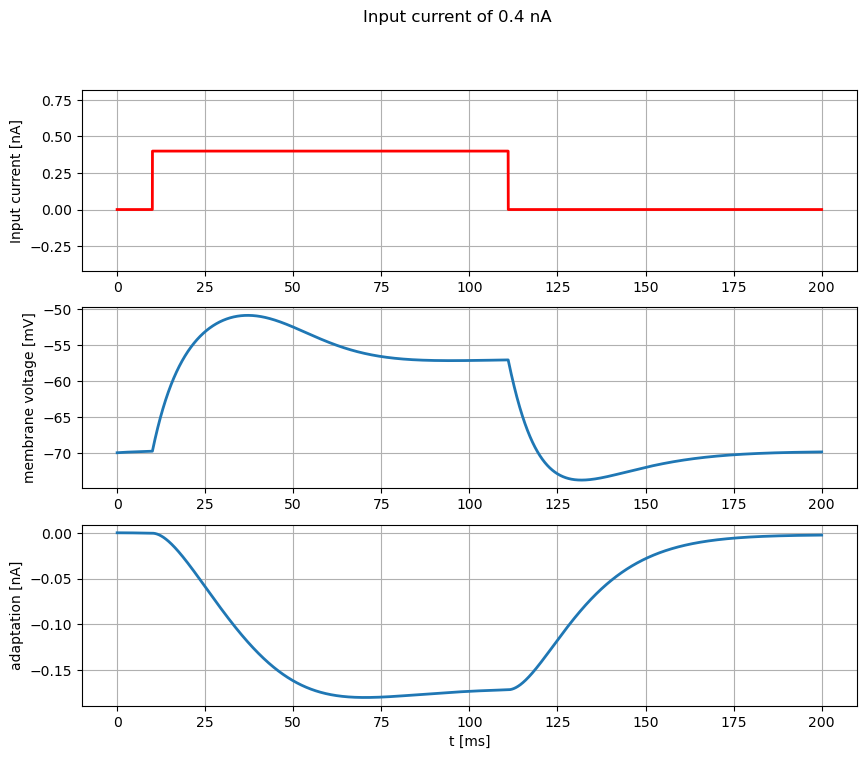

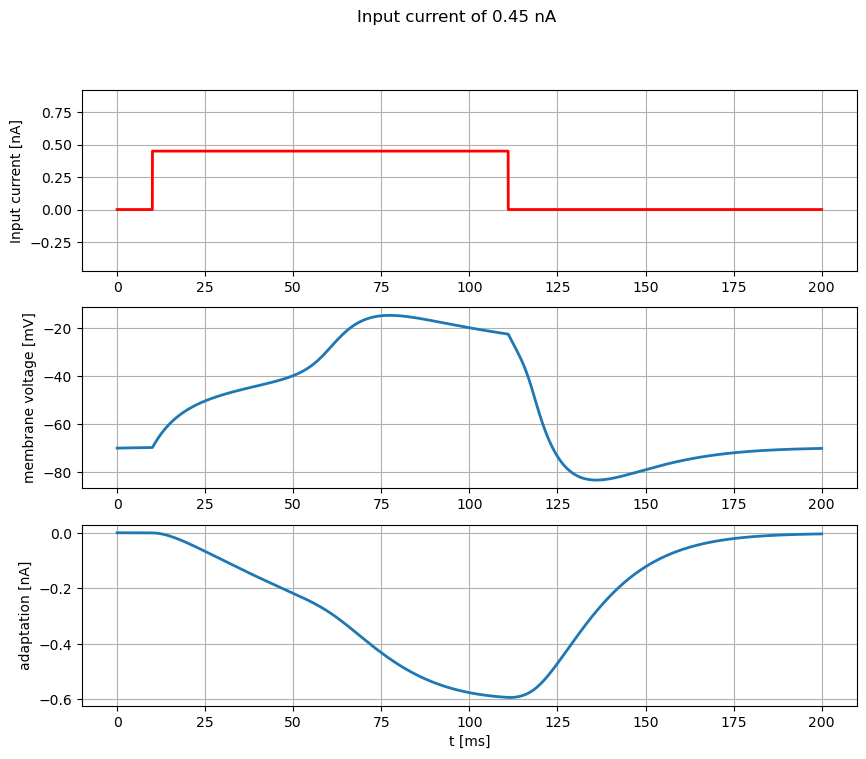

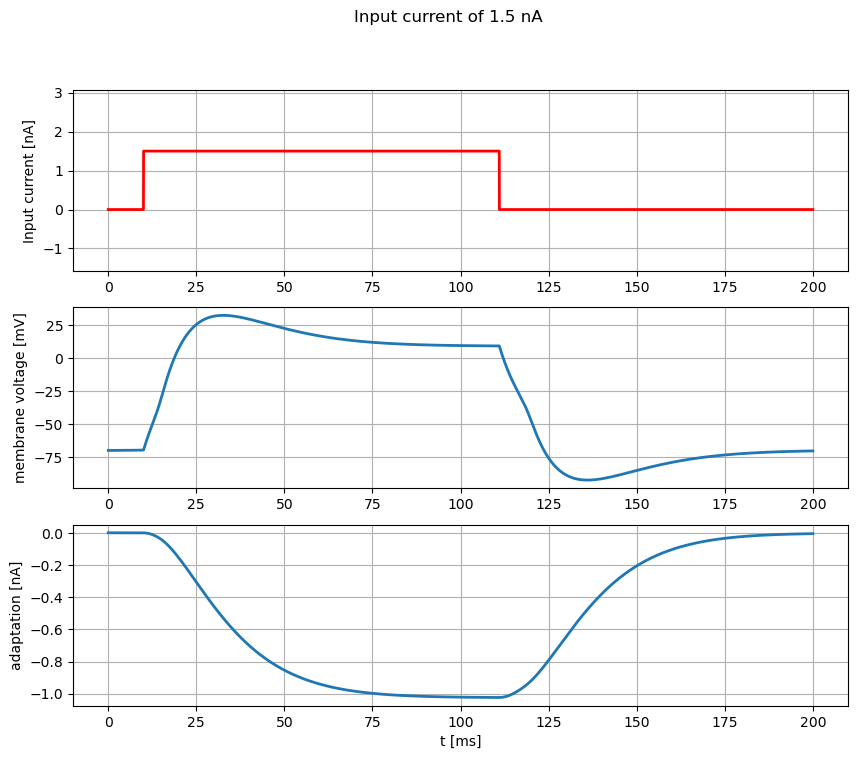

(<Axes: ylabel='Input current [nA]'>,
 <Axes: ylabel='membrane voltage [mV]'>,
 <Axes: xlabel='t [ms]', ylabel='adaptation [nA]'>)

In [4]:
current_1 = input_factory.get_step_current(10, 110, b2.ms, 0.4*b2.nA)
state_monitor_1= simulate_dendrite(I_stim=current_1)
plot_voltage_activation_and_current_traces(state_monitor_1, current_1, title='Input current of 0.4 nA')

current_2 = input_factory.get_step_current(10, 110, b2.ms, 0.45*b2.nA)
state_monitor_2= simulate_dendrite(I_stim=current_2)
plot_voltage_activation_and_current_traces(state_monitor_2, current_2, title='Input current of 0.45 nA')

current_3 = input_factory.get_step_current(10, 110, b2.ms, 1.5*b2.nA)
state_monitor_3= simulate_dendrite(I_stim=current_3)
plot_voltage_activation_and_current_traces(state_monitor_3, current_3, title='Input current of 1.5 nA')



## Question 1.2

In [5]:
def plot_derivative(voltage_monitor, current):

    start_idx = np.nonzero(np.squeeze(current.values))[0][0]
    stop_idx = np.argmax(voltage_monitor[0].v / b2.mV)
    amp = max(np.squeeze(current.values))

    voltage = voltage_monitor[0].v / b2.mV
    rising_v = (voltage)[start_idx:stop_idx]

    v_dev = rising_v - voltage[(start_idx-1):(stop_idx-1)]

    plt.figure(1, figsize=(15,4))
    plt.plot(rising_v, v_dev, lw = 2, label = 'input current of {} nA'.format(amp / b2.nA))
    plt.title('Finite difference derivative of the dendrite voltage')
    plt.xlabel('rising voltage')
    plt.ylabel('finite difference derivative')    
    plt.grid()
    plt.legend()




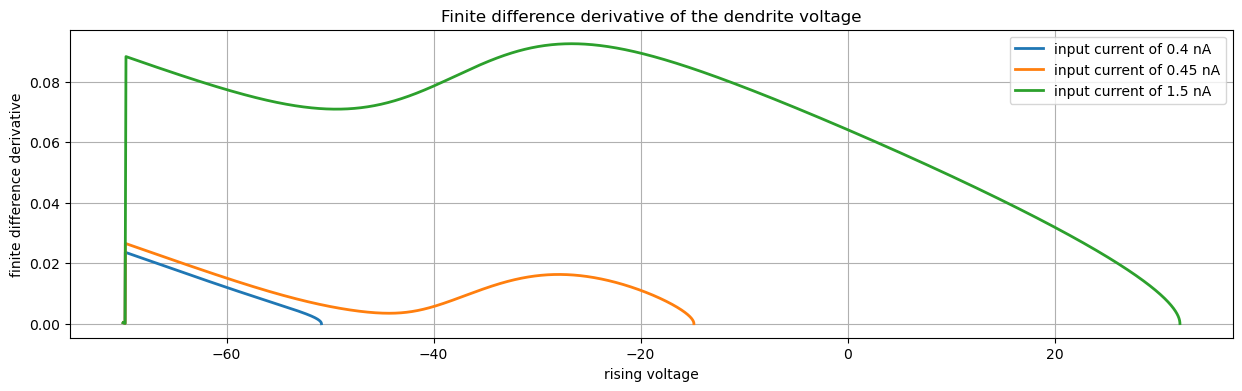

In [6]:
plot_derivative(state_monitor_1, current_1)
plot_derivative(state_monitor_2, current_2)
plot_derivative(state_monitor_3, current_3)

### Hint:

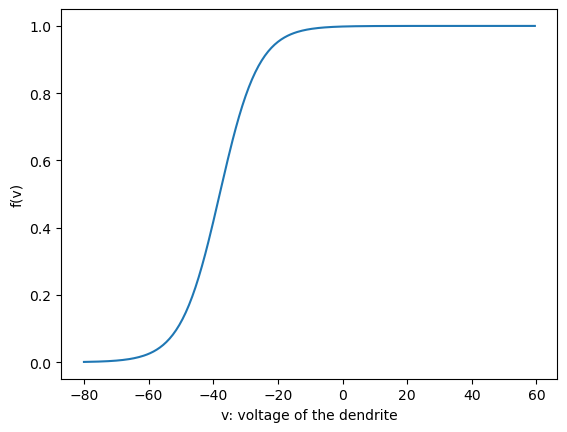

In [7]:
v_ = np.arange(-80, 60, 0.5)
f_ = 1/(1 + np.exp(-(v_+ 38.0)/6.0))

plt.plot(v_, f_)
plt.ylabel('f(v)')
plt.xlabel('v: voltage of the dendrite')
plt.show()

## Question 1.3

- have the dendritic spike happen with less current : decrease capacitance (eg: 70pF --> current 0.2 nA)

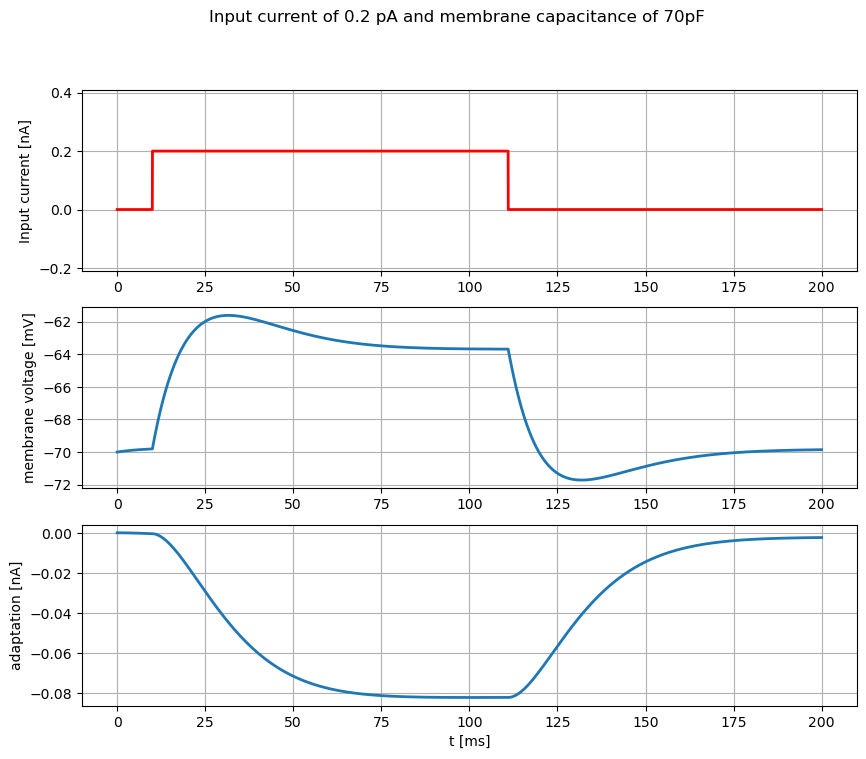

(<Axes: ylabel='Input current [nA]'>,
 <Axes: ylabel='membrane voltage [mV]'>,
 <Axes: xlabel='t [ms]', ylabel='adaptation [nA]'>)

In [8]:
current= input_factory.get_step_current(10, 110, b2.ms, 0.2*b2.nA)
state_monitor= simulate_dendrite(I_stim=current)
plot_voltage_activation_and_current_traces(state_monitor, current, title='Input current of 0.2 pA and membrane capacitance of 70pF')

- Increase the spike plateau potential when the current injection is fixed at 0.45nA 

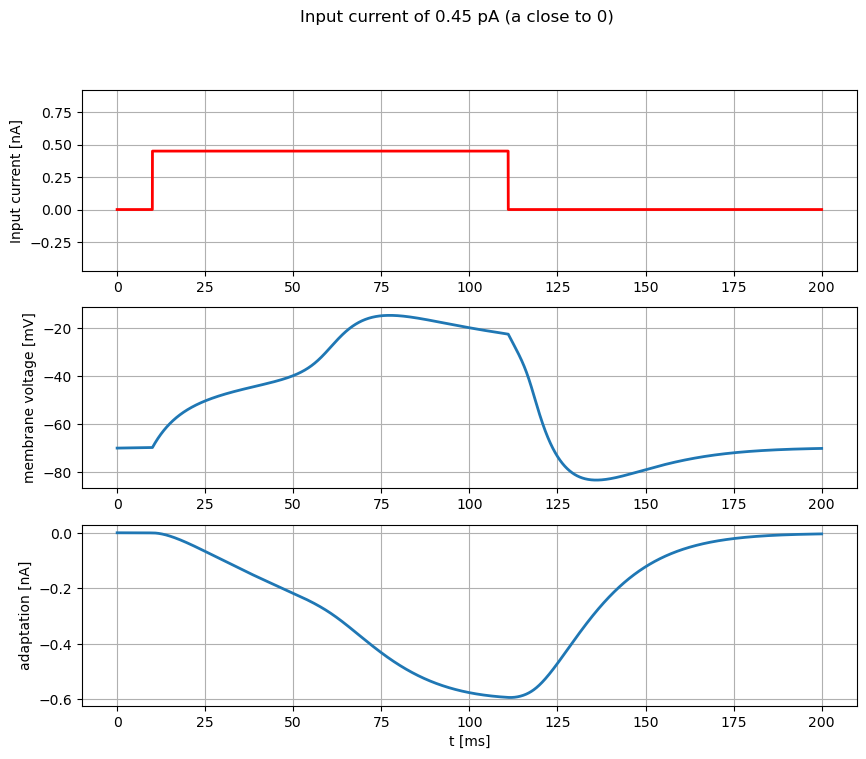

(<Axes: ylabel='Input current [nA]'>,
 <Axes: ylabel='membrane voltage [mV]'>,
 <Axes: xlabel='t [ms]', ylabel='adaptation [nA]'>)

In [9]:
current= input_factory.get_step_current(10, 110, b2.ms, 0.45*b2.nA)
state_monitor= simulate_dendrite(I_stim=current)
plot_voltage_activation_and_current_traces(state_monitor, current, title='Input current of 0.45 pA (a close to 0)')